# Graph Learning
## Lab 5: Heat Diffusion

In this lab, you will learn to use heat diffusion for **contrastive ranking** and **node classification**.

## Import

In [ ]:
from IPython.display import SVG

In [ ]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt

In [ ]:
!pip install scikit-network

In [ ]:
from sknetwork.data import load_netset, grid, karate_club
from sknetwork.regression import Dirichlet
from sknetwork.classification import DiffusionClassifier
from sknetwork.ranking import PageRank
from sknetwork.utils import directed2undirected
from sknetwork.visualization import visualize_graph
from sklearn.metrics import accuracy_score
from sknetwork.ranking import PageRank

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph + bipartite graph)

In [ ]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Grid

We first illustrate the notion of **contrastive ranking** on a $k\times k$ grid.

In [ ]:
k = 5
dataset = grid(k, k, True)
adjacency = dataset.adjacency
position = dataset.position

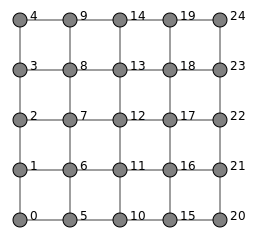

In [ ]:
image = visualize_graph(adjacency, position, names=np.arange(k * k), width=200, height=200)
SVG(image)

## To do

* Display the solution to the Dirichlet problem with 1 hot source and 1 cold source, located on the opposite corners of the square.
* Add a hot source at the top-left corner of the square. What is the free node of highest temperature?

In [ ]:
dirichlet = Dirichlet()

In [ ]:
bottom_left = 0
top_right = k * k - 1

In [ ]:
values = {bottom_left: 0, top_right: 1}

In [ ]:
temperatures = dirichlet.fit_predict(adjacency, values=values)

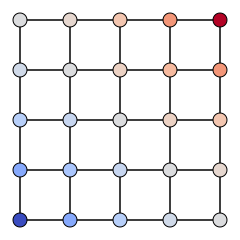

In [ ]:
image = visualize_graph(adjacency, position, scores=temperatures, width=200, height=200)
SVG(image)

Adding hot source at the top-left corner

In [ ]:
top_left=k-1

In [ ]:
values[top_left]=1

In [ ]:
new_temperatures=dirichlet.fit_predict(adjacency,values=values)

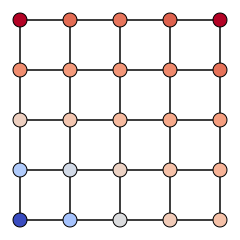

In [ ]:
image = visualize_graph(adjacency, position, scores=new_temperatures, width=200, height=200)
SVG(image)

In [ ]:
free_nodes=[i for i in range(k*k) if i not in values]
free_temperatures=new_temperatures[free_nodes]
max_index=free_nodes[np.argmax(free_temperatures)]

print("The free node(s) of highest temperature is ",max_index)
print("with a temperature of ",np.max(free_temperatures))

The free node(s) of highest temperature is  19
with a temperature of  0.8706544548145395


## Karate Club


We now consider the **classification** of nodes by heat diffusion. We use the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) that has ground-truth labels.

In [ ]:
dataset = karate_club(True)

In [ ]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

In [ ]:
n = len(labels_true)

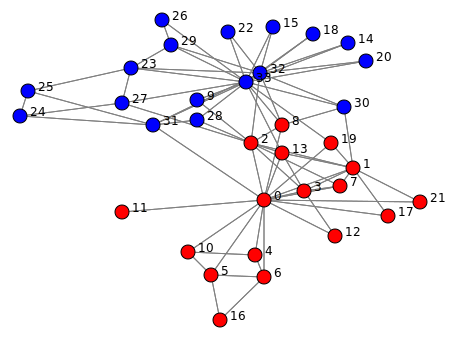

In [ ]:
image = visualize_graph(adjacency, position, labels=labels_true, names=np.arange(n))
SVG(image)

## To do

* Select one node in each ground-truth cluster, and predict the labels of the other nodes by heat diffusion.
* Display the graph with the predicted labels.
* What is the accuracy of the classification?

In [ ]:
unique_labels=np.unique(labels_true)
seeds={}

for label in unique_labels:
  index=np.where(labels_true==label)[0][0]
  seeds[index]=label

In [ ]:
classifier = DiffusionClassifier()
labels_pred=classifier.fit_predict(adjacency,seeds)

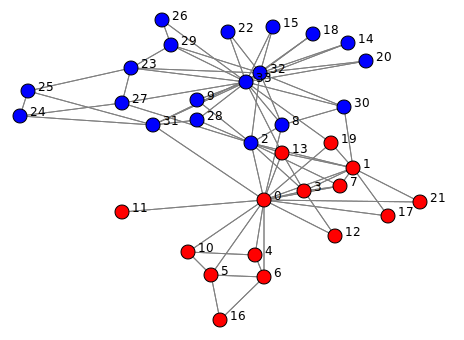

In [ ]:
image = visualize_graph(adjacency, position, labels=labels_pred, names=np.arange(n))
display(SVG(image))

In [ ]:
accuracy = accuracy_score(labels_true, labels_pred)
print("Classification accuracy:", accuracy)

Classification accuracy: 0.9411764705882353


In [ ]:
from sknetwork.ranking import Betweenness

centrality = Betweenness().fit_predict(adjacency)
unique_labels=np.unique(labels_true)
seeds={}

In [ ]:
for label in unique_labels:
    class_nodes = np.where(labels_true == label)[0]
    best_node = class_nodes[np.argmax(centrality[class_nodes])]
    seeds[best_node] = label
    print(best_node)

33
0


In [ ]:
classifier = DiffusionClassifier()
labels_pred = classifier.fit_predict(adjacency, seeds)

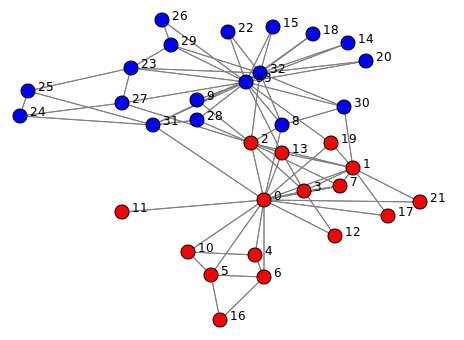

In [ ]:
image = visualize_graph(adjacency, position, labels=labels_pred, names=np.arange(n))
display(SVG(image))

In [ ]:
accuracy = accuracy_score(labels_true, labels_pred)
print("Classification accuracy:", accuracy)

Classification accuracy: 0.9705882352941176


After choosing the nodes based on the betweenness the accuracy increased.

## To do

The classifier applies temperature centering after diffusion.

* Repeat the same experiment without temperature centering.
* Do the same experiments with 3 nodes in a ground-truth cluster and 1 in the other.
* Comment the results.

In [ ]:
def run_experiment(seeds, centering):
    classifier = DiffusionClassifier(centering=centering)
    labels_pred = classifier.fit_predict(adjacency, seeds)

    acc = accuracy_score(labels_true, labels_pred)
    title = f"Centering={'On' if centering else 'Off'}, Seeds={seeds}"

    print(title)
    print("Accuracy:", acc)
    image = visualize_graph(adjacency, position, labels=labels_pred, names=np.arange(n))
    display(SVG(image))
    return acc

=== 1 seed per cluster ===
Centering=On, Seeds={9: np.int64(0), 0: np.int64(1)}
Accuracy: 0.9411764705882353


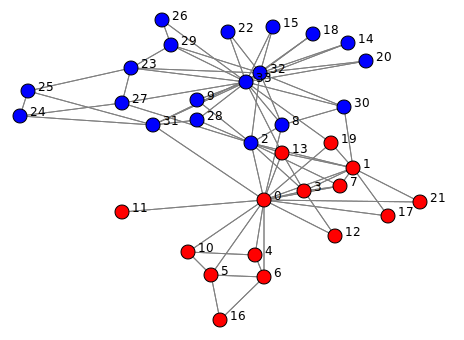

Centering=Off, Seeds={9: np.int64(0), 0: np.int64(1)}
Accuracy: 0.5294117647058824


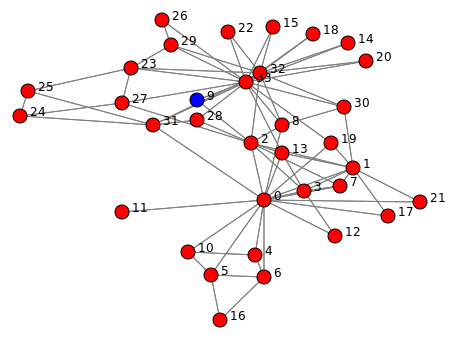

In [ ]:
print("=== 1 seed per cluster ===")
# Choose one node from each class
seeds_balanced = {}
for label in unique_labels:
    idx = np.where(labels_true == label)[0][:1]
    seeds_balanced[int(idx[0])] = label

acc1 = run_experiment(seeds_balanced, centering=True)
acc2 = run_experiment(seeds_balanced, centering=False)


=== 3 vs 1 seed imbalance ===
Centering=On, Seeds={9: np.int64(0), 14: np.int64(0), 15: np.int64(0), 0: np.int64(1)}
Accuracy: 0.9411764705882353


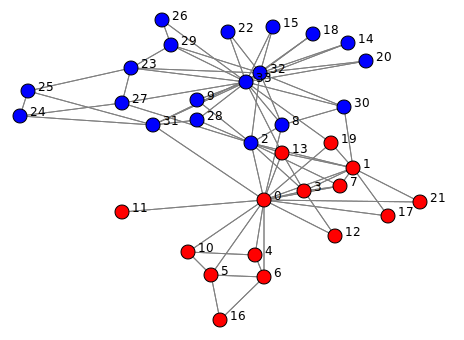

Centering=Off, Seeds={9: np.int64(0), 14: np.int64(0), 15: np.int64(0), 0: np.int64(1)}
Accuracy: 0.8529411764705882


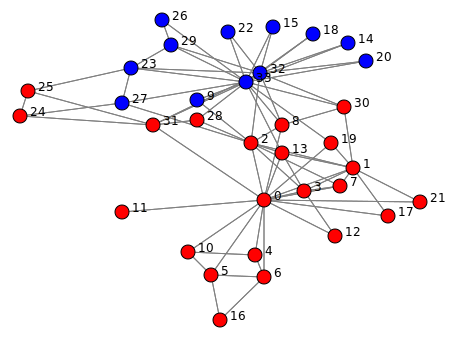

In [ ]:
print("\n=== 3 vs 1 seed imbalance ===")
label_majority = unique_labels[0]
label_minority = unique_labels[1]

seeds_unbalanced = {}
seeds_unbalanced.update({int(i): label_majority for i in np.where(labels_true == label_majority)[0][:3]})
seeds_unbalanced[int(np.where(labels_true == label_minority)[0][0])] = label_minority

acc3 = run_experiment(seeds_unbalanced, centering=True)
acc4 = run_experiment(seeds_unbalanced, centering=False)

When temperature centering is disabled, the diffusion process tends to favor the class with more seeds. This is especially evident in the unbalanced (3 vs 1) case, where many nodes are incorrectly labeled due to temperature bias. With centering enabled, label propagation becomes more stable and accurate even with uneven seeding (maintaining an accuracy of 0.941), showing that centering is crucial for fairness in diffusion-based classification.

## Openflights


We now show how to classify the nodes of a graph **without labels**. We identify some nodes of interest and use these seeds to classify the other nodes.

In [ ]:
dataset = openflights

In [ ]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

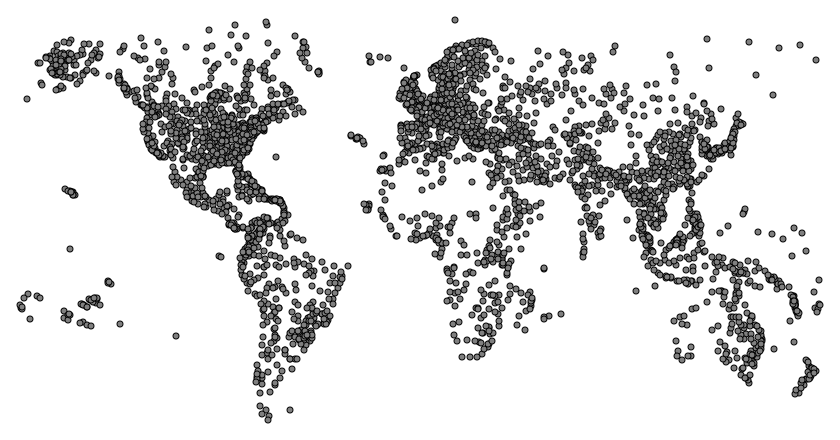

In [ ]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the labels predicted for 3 seeds (Paris, New-York, Beijing), each with its own  label.
* Add Madrid with another label and comment the results.

In [ ]:
paris = 622
newyork = 1842
beijing = 1618
madrid = 572

In [ ]:
classifier= DiffusionClassifier()
seeds={}
seeds[paris]=0
seeds[newyork]=1
seeds[beijing]=2

In [ ]:
labels_pred=classifier.fit_predict(adjacency,seeds)

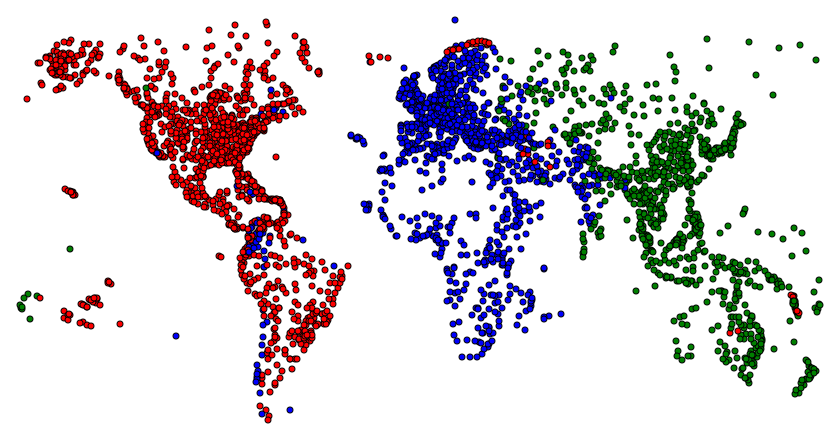

In [ ]:
image = visualize_graph(adjacency, position, labels=labels_pred, width=800, height=400, node_size=3, display_edges=False)
display(SVG(image))

In [ ]:
seeds[madrid]=3
classifier= DiffusionClassifier()
labels_pred=classifier.fit_predict(adjacency,seeds)

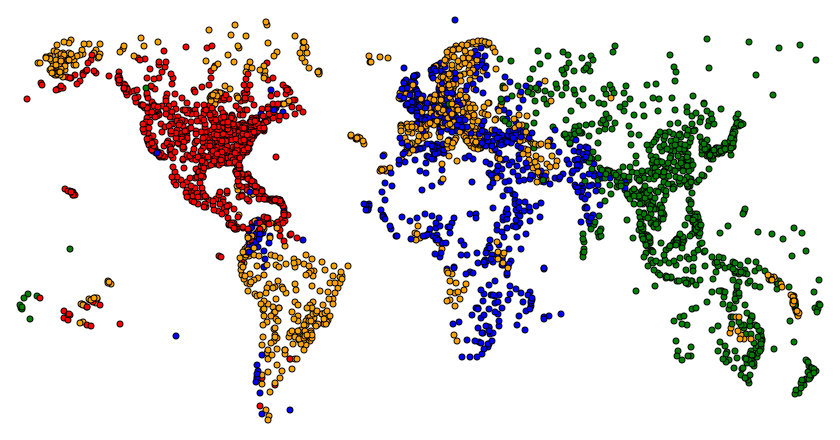

In [ ]:
image = visualize_graph(adjacency, position, labels=labels_pred, width=800, height=400, node_size=3, display_edges=False)
display(SVG(image))

After adding Madrid Paris has a new competitor in Europe and New York in America. Madrid pulled almost all the airports in South America and an important part of Europe as well. However, Paris maintained its position as a key airport with Africa.

Finally, we illustrate **contrastive ranking** on Openflights.

In [ ]:
dirichlet = Dirichlet()

In [ ]:
values = {paris: 0, beijing: 1}

In [ ]:
temperatures = dirichlet.fit_predict(adjacency, values=values)

Contrast ranking between Paris and Beijing


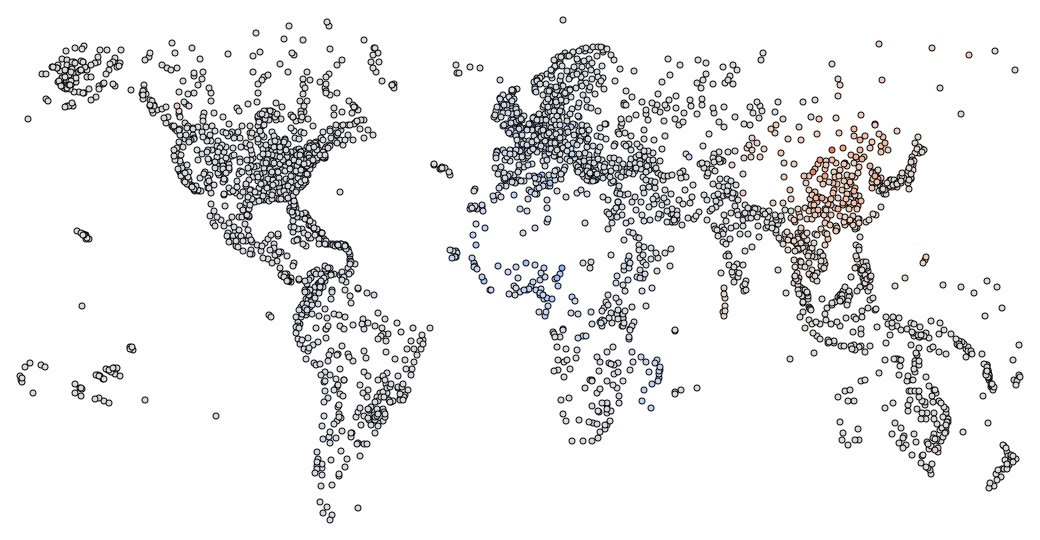

In [ ]:
print("Contrast ranking between Paris and Beijing")
image = visualize_graph(adjacency, position, scores=temperatures, width=1000, height=500, node_size=3, display_edges=False)
SVG(image)

In [ ]:
values = {paris: 0, newyork: 1}

In [ ]:
temperatures = dirichlet.fit_predict(adjacency, values=values)

Contrast ranking between Paris and Newyork


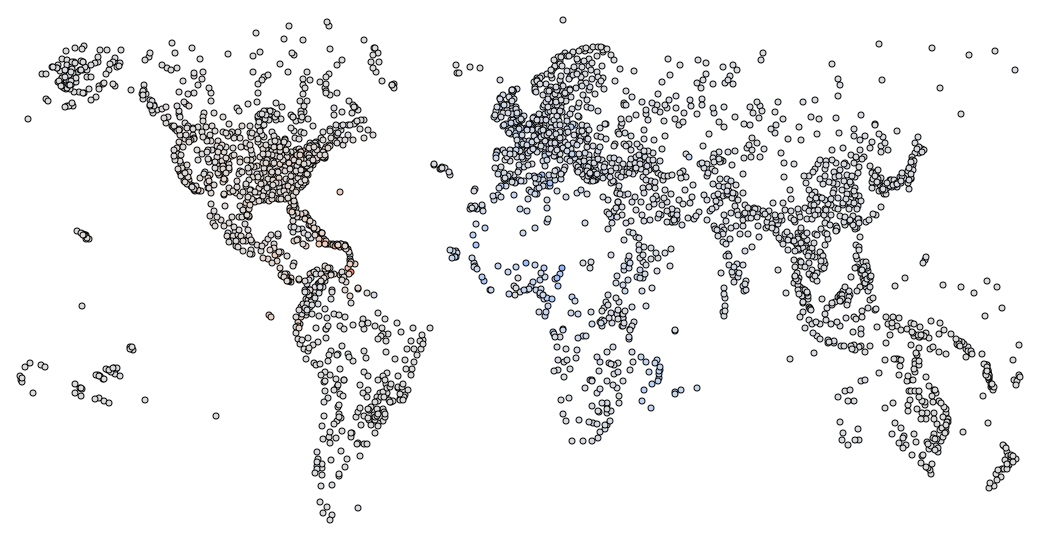

In [ ]:
print("Contrast ranking between Paris and Newyork")
image = visualize_graph(adjacency, position, scores=temperatures, width=1000, height=500, node_size=3, display_edges=False)
SVG(image)

In [ ]:
values = {beijing: 0, newyork: 1}

In [ ]:
temperatures = dirichlet.fit_predict(adjacency, values=values)

Contrast ranking between Beijing and Newyork


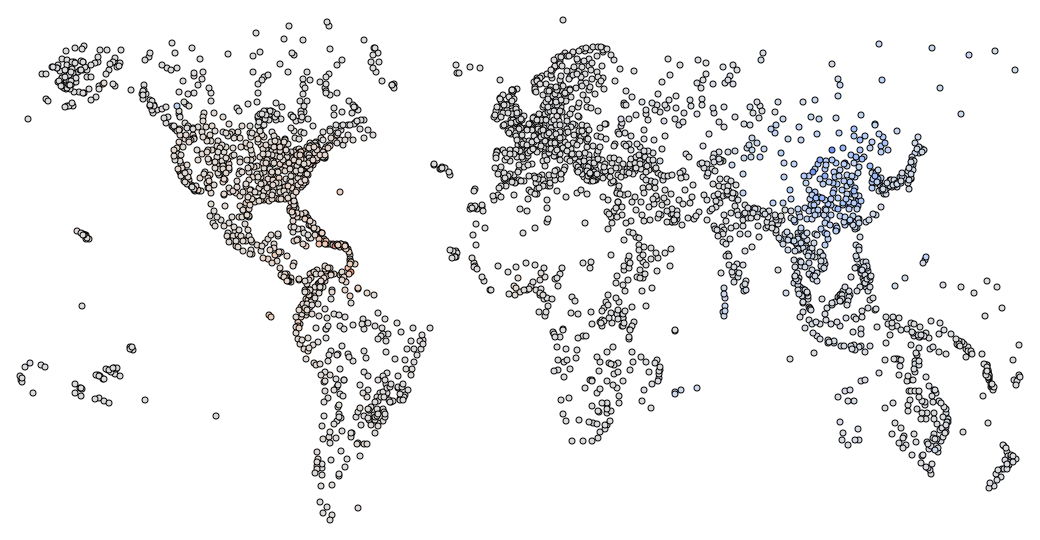

In [ ]:
print("Contrast ranking between Beijing and Newyork")
image = visualize_graph(adjacency, position, scores=temperatures, width=1000, height=500, node_size=3, display_edges=False)
SVG(image)

## To do

* List the top-10 airports that are the closest to Tokyo in terms of Personalized PageRank.
* List of the top-10 airports that are both the closest to Tokyo and the furthest from Paris Charles de Gaulle, using heat diffusion (contrastive ranking).<br>What do you observe?
* Give the temperatures of these airports after heat diffusion and explain the result.

In [ ]:
tokyo = 1084

In [ ]:
pr=PageRank()

In [ ]:
scores = pr.fit_predict(adjacency, weights={tokyo:1})
print(scores)

[5.32886612e-05 7.85872321e-05 1.71586149e-04 ... 2.80844124e-05
 8.63664996e-06 1.16807427e-05]


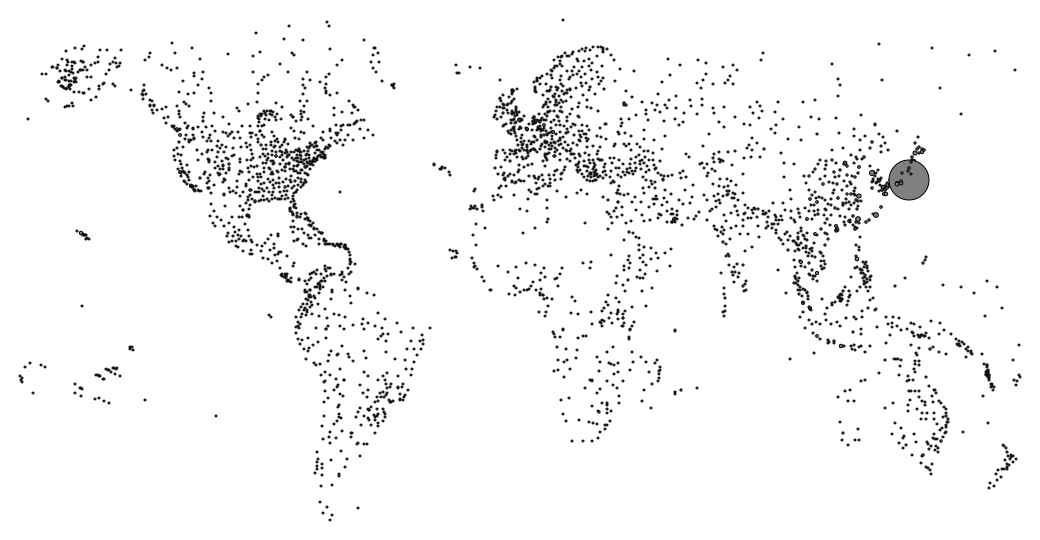

In [ ]:
image = visualize_graph(adjacency, position, node_weights=scores, width=1000, height=500, node_size=3, display_edges=False)
SVG(image)

In [ ]:
top_10_pagerank_index=np.argsort(scores)[-11:][::-1]
top_10_pagerank=names[top_10_pagerank_index]
print("Top 10 airports closest to Tokyo (without including the Tokyo airport):")
for i in range(2,12):
    print("Top ",i-1,end="")
    print(": ",top_10_pagerank[i-1])

Top 10 airports closest to Tokyo (without including the Tokyo airport):
Top  1:  Incheon International Airport
Top  2:  Naha Airport
Top  3:  Taiwan Taoyuan International Airport
Top  4:  Osaka International Airport
Top  5:  Shanghai Pudong International Airport
Top  6:  New Chitose Airport
Top  7:  Kansai International Airport
Top  8:  Narita International Airport
Top  9:  Chubu Centrair International Airport
Top  10:  Chek Lap Kok International Airport


In [ ]:
dirichlet = Dirichlet()

In [ ]:
values = {paris: 0, tokyo: 1}

In [ ]:
temperatures = dirichlet.fit_predict(adjacency, values=values)

Contrast ranking between Paris and Tokyo


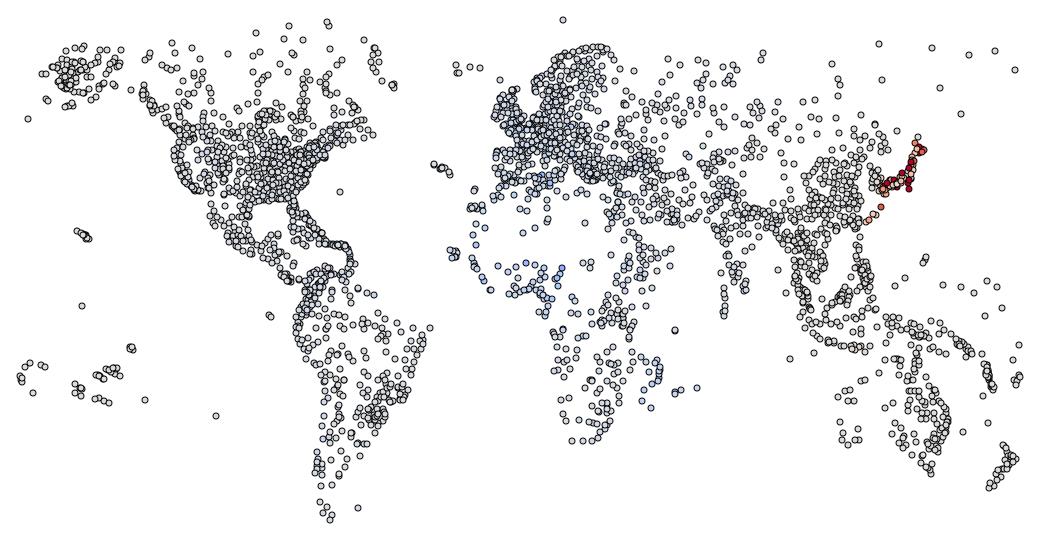

In [ ]:
print("Contrast ranking between Paris and Tokyo")
image = visualize_graph(adjacency, position, scores=temperatures, width=1000, height=500, node_size=3, display_edges=False)
SVG(image)

In [ ]:
top_10_temp_index=np.argsort(temperatures)[-11:][::-1]
top_10_temp=names[top_10_temp_index]
print("Top 10 airports closest to Tokyo and furthest from Paris Charles de Gaulle:")
for i in range(0,10):
    print("Top ",i+1,end="")
    print(": ",top_10_temp[i])

Top 10 airports closest to Tokyo and furthest from Paris Charles de Gaulle:
Top  1:  Tokachi-Obihiro Airport
Top  2:  Nanki Shirahama Airport
Top  3:  Odate Noshiro Airport
Top  4:  Monbetsu Airport
Top  5:  Hachijojima Airport
Top  6:  Tokyo Haneda International Airport
Top  7:  Oshima Airport
Top  8:  Noto Airport
Top  9:  Tottori Airport
Top  10:  Tokushima Airport


As we expected, the airports are all clearly closer to Tokyo than to Paris. But Tokyo is not in the 1st place, which is strange since it's impossible for the other nodes to have a higher value than its temperature. This is suggesting that maybe some of the airports have the highest possible temperature in the graph. Finally, in order to clear the list, we'll get out of the top the Tokyo airport.

In [ ]:
temperatures[tokyo]=0
top_10_temp_index=np.argsort(temperatures)[-11:][::-1]
top_10_temp=names[top_10_temp_index]
print("Top 10 airports closest to Tokyo and furthest from Paris Charles de Gaulle:")
for i in range(0,10):
    print("Top ",i+1,end="")
    print(": ",top_10_temp[i])

Top 10 airports closest to Tokyo and furthest from Paris Charles de Gaulle:
Top  1:  Hachijojima Airport
Top  2:  Oshima Airport
Top  3:  Izumo Airport
Top  4:  Tokushima Airport
Top  5:  Noto Airport
Top  6:  Tottori Airport
Top  7:  Shonai Airport
Top  8:  Iwami Airport
Top  9:  Odate Noshiro Airport
Top  10:  Monbetsu Airport


In [ ]:
print("Temperatures of the top 10 airports closest to Tokyo and furthest from Paris Charles de Gaulle:")
print(temperatures[top_10_temp_index])

Temperatures of the top 10 airports closest to Tokyo and furthest from Paris Charles de Gaulle:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


As we can see the temperatures of the airports is 1 in all the cases, indicating that its connection with the Tokyo airport is the only way to arrive to the Paris airport, otherwise the low temperature of the Paris node would have had an effect.

## Wikipedia Vitals

We now consider the graph of links of WikiVitals, considered as undirected. We first focus on **constrastive ranking**, then on **node classification**.

In [ ]:
dataset = wikivitals

In [ ]:
adjacency = dataset.adjacency
names = dataset.names
labels = dataset.labels
names_labels = dataset.names_labels

In [ ]:
adjacency = directed2undirected(adjacency)

## Contrastive ranking

## To do

* List the top-10 articles that are close to **Cat** and **Dog** in terms of Personalized PageRank.
* Compare with the list of top-10 articles that are close to **Cat** and **Dog** and far from **Bear** and **Tiger** using heat diffusion (contrastive ranking).
* List the top-10 articles that are close to **Bear** and **Tiger** and far from **Cat** and **Dog** (you can use previous diffusion). Interpret the results.

In [ ]:
pagerank = PageRank()

In [ ]:
pagerank.fit(adjacency, force_bipartite=True)

PageRank(damping_factor=0.85, solver='piteration', n_iter=10, tol=1e-06)

In [ ]:
i_cat = np.where(names == 'Cat')[0][0]
i_dog = np.where(names == 'Dog')[0][0]

In [ ]:
weights={i_cat:1,i_dog:1}
scores=pagerank.fit_predict(adjacency,weights=weights,force_bipartite=True)

In [ ]:
top_10_pagerank_index=np.argsort(scores)[-12:][::-1]
top_10_pagerank=names[top_10_pagerank_index]
print("Top 10 articles closest to 'Cat' and 'Dog' without including them:")
for i in range(3,13):
    print("Top ",i-2,end="")
    print(": ",top_10_pagerank[i-1])

Top 10 articles closest to 'Cat' and 'Dog' without including them:
Top  1:  Animal
Top  2:  Taxonomy (biology)
Top  3:  Mammal
Top  4:  Coyote
Top  5:  Chordate
Top  6:  Lion
Top  7:  Pinniped
Top  8:  Tiger
Top  9:  Brown bear
Top  10:  Bear


In [ ]:
i_bear = np.where(names == 'Bear')[0][0]
i_tiger = np.where(names == 'Tiger')[0][0]

In [ ]:
dirichlet = Dirichlet()

In [ ]:
values=weights
values[i_bear]=0
values[i_tiger]=0

In [ ]:
temperatures = dirichlet.fit_predict(adjacency, values=values)

In [ ]:
top_10_temp_index=np.argsort(temperatures)[-12:][::-1]
top_10_temp=names[top_10_temp_index]

print("Top 10 articles closest to 'Cat' and 'Dog' and furthest from 'Bear' and 'Tiger' without including them:")
for i in range(3,13):
    print("Top ",i-2,end="")
    print(": ",top_10_temp[i-1])

Top 10 articles closest to 'Cat' and 'Dog' and furthest from 'Bear' and 'Tiger' without including them:
Top  1:  Domestic short-haired cat
Top  2:  Terrier
Top  3:  Retriever
Top  4:  Siamese cat
Top  5:  Great Dane
Top  6:  German Shepherd
Top  7:  Skink
Top  8:  Lyrebird
Top  9:  Pet
Top  10:  Budgerigar


In [ ]:
values={i_cat:0,i_dog:0,i_bear:1,i_tiger:1}
temperatures = dirichlet.fit_predict(adjacency, values=values)

In [ ]:
top_10_temp_index=np.argsort(temperatures)[-12:][::-1]
top_10_temp=names[top_10_temp_index]
print("Top 10 articles closest to 'Bear' and 'Tiger' and furthest from 'Cat' and 'Dog' without including them:")
for i in range(3,13):
    print("Top ",i-2,end="")
    print(": ",top_10_temp[i-1])

Top 10 articles closest to 'Bear' and 'Tiger' and furthest from 'Cat' and 'Dog' without including them:
Top  1:  Serranidae
Top  2:  Stuffed toy
Top  3:  Winnie-the-Pooh
Top  4:  Hibernation
Top  5:  Legendary creature
Top  6:  Shaving
Top  7:  Korean mythology
Top  8:  Mount St. Helens
Top  9:  Ursa Major
Top  10:  Zoo


Personalized PageRank with Cat and Dog highlights broad, central concepts like Animal, Taxonomy, and Mammal, reflecting their global influence in the Wikipedia graph. It also ranks other large carnivores due to strong link connections.

With contrastive diffusion (Cat and Dog as hot, Bear and Tiger as cold), the ranking shifts toward domestic and pet-related topics—especially specific breeds and more unique pets like Skink, Lyrebird, or Parakeet that are linked to cats and dogs but not to wild animals.

Reversing the contrast (Bear and Tiger hot, Cat and Dog cold) reveals topics tied to wild or symbolic animals—like Hibernation, Winnie the Pooh, Korean mythology, or zoos—which are related to bears and tigers but not domestic pets.

In short, PageRank surfaces general relevance, while contrastive diffusion sharpens focus on topic-specific communities by subtracting shared influence.

## Node classification

We now use the ground-truth labels provided by the category of each article.

In [ ]:
print(names_labels)

['Arts' 'Biological and health sciences' 'Everyday life' 'Geography'
 'History' 'Mathematics' 'People' 'Philosophy and religion'
 'Physical sciences' 'Society and social sciences' 'Technology']


## To do

* What is the accuracy of node classification, using half of the nodes in the train set?
* Display the confusion matrix. What is the most difficult class to predict?
* Give examples of misclassification for each label (e.g., 2 false positives and 2 false negatives per label).

In [ ]:
n = len(labels)

In [ ]:
index = np.arange(n)
rng = np.random.default_rng(42)
train_idx = rng.choice(index, size=n//2, replace=False)
test_idx = np.setdiff1d(index, train_idx)

In [ ]:
seeds = {i: labels[i] for i in train_idx}

classifier = DiffusionClassifier()
labels_pred = classifier.fit_predict(adjacency, seeds)

In [ ]:
accuracy = np.mean(labels_pred[test_idx] == labels[test_idx])

print(f"\nAccuracy of the test with 50% of the data for training: {accuracy:.3%}")


Accuracy of the test with 50% of the data for training: 74.850%


In [ ]:
from sklearn.metrics import confusion_matrix
from collections import defaultdict

cm = confusion_matrix(labels[test_idx], labels_pred[test_idx], labels=np.arange(len(names_labels)))
df_cm = pd.DataFrame(cm, index=names_labels, columns=names_labels)
print("\nConfusion matrix:")
print(df_cm)


Confusion matrix:
                                Arts  Biological and health sciences  \
Arts                             183                               5   
Biological and health sciences     0                             685   
Everyday life                      0                              24   
Geography                          0                               4   
History                            2                               4   
Mathematics                        0                               0   
People                            77                              15   
Philosophy and religion            0                               1   
Physical sciences                  0                               8   
Society and social sciences        4                               2   
Technology                         6                              12   

                                Everyday life  Geography  History  \
Arts                                        3  

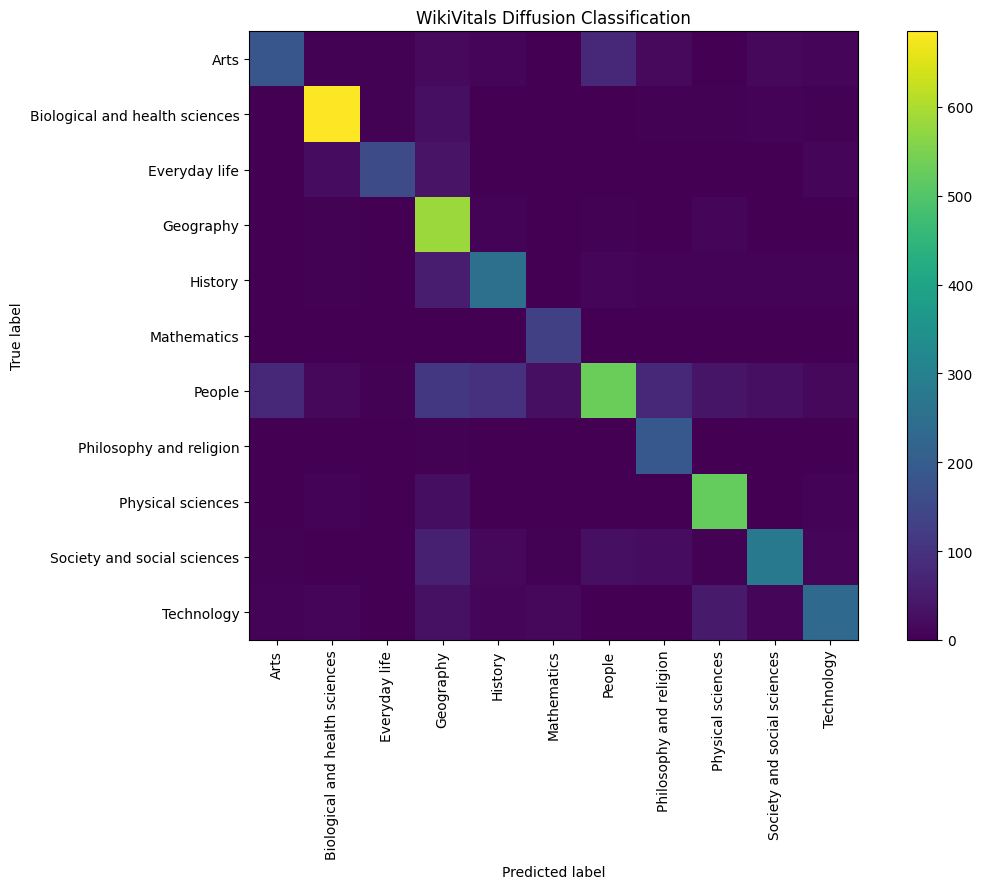



Based on the recall, the class most difficult to predict is 'People' with 51.657%


In [ ]:
plt.figure(figsize=(12,9))
plt.imshow(cm, interpolation='nearest')
plt.xticks(np.arange(len(names_labels)), names_labels, rotation=90)
plt.yticks(np.arange(len(names_labels)), names_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('WikiVitals Diffusion Classification')
plt.colorbar()
plt.tight_layout()
plt.show()

recall = np.diag(cm) / cm.sum(axis=1)
hardest = names_labels[np.argmin(recall)]
print(f"\n\nBased on the recall, the class most difficult to predict is '{hardest}' with {recall.min():.3%}")

In [ ]:
false_negatives = defaultdict(list)
false_positives = defaultdict(list)

In [ ]:
for i in test_idx:
    true = labels[i]
    pred = labels_pred[i]
    if true != pred:
        if len(false_negatives[true]) < 2:
            false_negatives[true].append(i)
        if len(false_positives[pred]) < 2:
            false_positives[pred].append(i)

In [ ]:
for cls in range(len(names_labels)):
    print(f"\nClass '{names_labels[cls]}':")
    negatives = false_negatives[cls]
    positives = false_positives[cls]
    if negatives:
        print("  False negatives:")
        for i in negatives:
            print(f"    - {names[i]} (Predicted: '{names_labels[labels_pred[i]]}')")
    if positives:
        print("  False positives:")
        for i in positives:
            print(f"    - {names[i]} (True: '{names_labels[labels[i]]}')")


Class 'Arts':
  False negatives:
    - A Doll's House (Predicted: 'People')
    - Aeneid (Predicted: 'Philosophy and religion')
  False positives:
    - Alexander Pope (True: 'People')
    - Andrea Palladio (True: 'People')

Class 'Biological and health sciences':
  False negatives:
    - Aloe (Predicted: 'Geography')
    - Arecaceae (Predicted: 'Geography')
  False positives:
    - Alexander Fleming (True: 'People')
    - Andreas Vesalius (True: 'People')

Class 'Everyday life':
  False negatives:
    - 100 metres (Predicted: 'Geography')
    - Angling (Predicted: 'Biological and health sciences')
  False positives:
    - Batman (True: 'Arts')
    - Celibacy (True: 'Philosophy and religion')

Class 'Geography':
  False negatives:
    - Bavaria (Predicted: 'History')
    - Cartography (Predicted: 'Physical sciences')
  False positives:
    - 100 metres (True: 'Everyday life')
    - 1556 Shaanxi earthquake (True: 'History')

Class 'History':
  False negatives:
    - 1556 Shaanxi earthq

## To do

* Classify each article of the **People** category in one of the other categories (Mathematics, History, etc.), using all other labels.
* List the top-5 predicted people of each category using Personalized PageRank.

In [ ]:
people_label = list(names_labels).index('People')
people_idx = np.where(labels == people_label)[0]

seeds = {i: labels[i] for i in range(len(labels)) if labels[i] != people_label}

clf = DiffusionClassifier()
labels_pred = clf.fit_predict(adjacency, seeds)

print("Number of 'People' articles in other category:")
for c_idx, c_name in enumerate(names_labels):
    if c_name == 'People':
        continue
    count = np.sum(labels_pred[people_idx] == c_idx)
    print(f"  {c_name}: {count}")

Number of 'People' articles in other category:
  Arts: 543
  Biological and health sciences: 34
  Everyday life: 21
  Geography: 344
  History: 384
  Mathematics: 42
  Philosophy and religion: 253
  Physical sciences: 110
  Society and social sciences: 224
  Technology: 36


In [ ]:
pr = PageRank(0.85)
print("Top-5 'People' articles per category using 'Personalized PageRank':\n")
for c_idx, c_name in enumerate(names_labels):
    if c_name == 'People':
        continue

    cat_nodes = np.where(labels == c_idx)[0]
    personalization = {i: 1.0 for i in cat_nodes}
    pr.fit(adjacency, personalization, force_bipartite=True)
    scores = pr.scores_

    people_in_cat = people_idx[labels_pred[people_idx] == c_idx]
    top5 = sorted(people_in_cat, key=lambda i: scores[i], reverse=True)[:5]

    print(f"\n{c_name}:")
    for rank, idx in enumerate(top5, start=1):
        print(f"Top {rank}. {names[idx]}")

Top-5 'People' articles per category using 'Personalized PageRank':


Arts:
Top 1. Pablo Picasso
Top 2. Bob Dylan
Top 3. Igor Stravinsky
Top 4. Thomas Mann
Top 5. Ludwig van Beethoven

Biological and health sciences:
Top 1. Carl Linnaeus
Top 2. Charles Darwin
Top 3. Antonie van Leeuwenhoek
Top 4. Galen
Top 5. Hippocrates

Everyday life:
Top 1. Margaret Mead
Top 2. Bruce Lee
Top 3. LeBron James
Top 4. Jackie Robinson
Top 5. Wayne Gretzky

Geography:
Top 1. Elizabeth II
Top 2. Christopher Columbus
Top 3. Dwight D. Eisenhower
Top 4. George W. Bush
Top 5. Vladimir Putin

History:
Top 1. Alexander the Great
Top 2. Napoleon
Top 3. Winston Churchill
Top 4. Augustus
Top 5. Joseph Stalin

Mathematics:
Top 1. Leonhard Euler
Top 2. Bernhard Riemann
Top 3. Henri Poincaré
Top 4. Archimedes
Top 5. David Hilbert

Philosophy and religion:
Top 1. Augustine of Hippo
Top 2. Plato
Top 3. Aristotle
Top 4. Thomas Aquinas
Top 5. Immanuel Kant

Physical sciences:
Top 1. Isaac Newton
Top 2. Albert Einstein
Top

## 2. Bipartite graphs

Finally, we consider the bipartite graph between articles and words in WikiVitals.

In [ ]:
dataset = wikivitals
biadjacency = dataset.biadjacency

In [ ]:
words = dataset.names_col

## To do

* Repeat the experiments on node classification using the bipartite graph between articles and words.
* Which information seems to be richer, the text or the links between articles?
* Propose a solution exploiting both sources of information.

In [ ]:
A_links = directed2undirected(dataset.adjacency)
B_text = dataset.biadjacency
labels = dataset.labels
names_labels = dataset.names_labels
n_art, n_words = B_text.shape
n_total = n_art + n_words

In [ ]:
rng = np.random.default_rng(42)
indices = np.arange(n_art)
train_art = rng.choice(indices, size=n_art//2, replace=False)
test_art = np.setdiff1d(indices, train_art)

In [ ]:
seeds_links = {i: labels[i] for i in train_art}
seeds_text = seeds_links.copy()
seeds_both = seeds_links.copy()

In [ ]:
clf = DiffusionClassifier()
pred_links = clf.fit_predict(A_links, seeds_links)
acc_links = (pred_links[test_art] == labels[test_art]).mean()
print(f"Accuracy using only links: {acc_links:.2%}")

Accuracy using only links: 74.85%


In [ ]:
clf = DiffusionClassifier()
pred_bip  = clf.fit_predict(B_text, seeds_text, force_bipartite=True)

pred_text = pred_bip[:n_art]
acc_text = (pred_text[test_art] == labels[test_art]).mean()
print(f"Accuracy using only text: {acc_text:.2%}")

Accuracy using only text: 80.38%


In [ ]:
top = sparse.hstack([A_links, B_text])
bottom = sparse.hstack([B_text.T, sparse.csr_matrix((n_words, n_words))])
A_fused = sparse.vstack([top, bottom])

clf = DiffusionClassifier()
pred_fused_all = clf.fit_predict(A_fused, seeds_both, force_bipartite=True)
pred_fused = pred_fused_all[:n_art]
acc_fused = (pred_fused[test_art] == labels[test_art]).mean()
print(f"Accuracy links+text: {acc_fused:.2%}")

Accuracy links+text: 81.44%


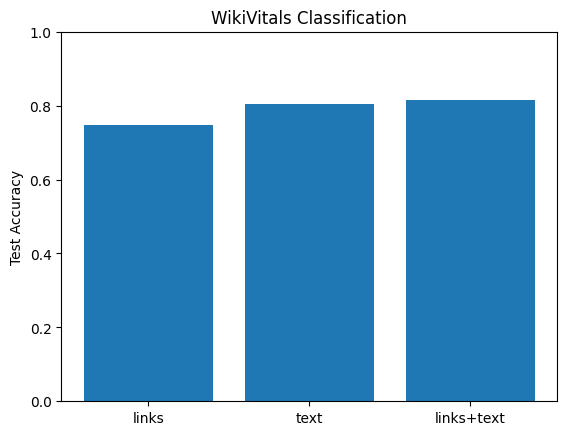

In [ ]:
plt.bar(['links','text','links+text'], [acc_links, acc_text, acc_fused])
plt.ylabel('Test Accuracy')
plt.title('WikiVitals Classification')
plt.ylim(0,1)
plt.show()